# ML pipeline for a single assay endpoint

### Imports

In [22]:
import os
import sys
from contextlib import redirect_stdout
import datetime
import yaml
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import set_config
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, fbeta_score, roc_curve, roc_auc_score
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, VarianceThreshold, SelectFromModel
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.decomposition import NMF
from plotnine import *
import plotnine


### Load assay endpoint and QSAR-ready chemical structure fingerprints
Note: Many chemicals from assays do not have a fingerprint -> small training data

In [23]:
# Define the root directory
ROOT_DIR = os.path.dirname(os.path.abspath("__file__"))
CONFIG_PATH = os.path.join(ROOT_DIR, 'config', 'config_ml.yaml')

def load_config(config_path):
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
        if config["ignore_warnings"]:
            import warnings
            warnings.filterwarnings("ignore")

    return config  

 
config = load_config(CONFIG_PATH)

print(f"ML pipeline for assay ID: {config['aeid']}\n")

# Prepare assay df
assay_file = f"{config['aeid']}.parquet.gzip"
rel_path = f"../../pytcpl/data/custom_output/{assay_file}"
assay_file_path = os.path.join(ROOT_DIR, rel_path)
assay_df = pd.read_parquet(assay_file_path)
print(f"Assay dataframe: {assay_df.shape[0]} chemical/hitcall datapoints")

# Prepare fingerprint df
# fingerprint_file = "ToxCast_CSIfps.csv"  # ToxCast_CSIfps_10k.csv, ToxCast_CSIfps.csv
fingerprint_file_parquet_gzip = "ToxCast_CSIfps_10k.parquet.gzip"
fps_file_path = os.path.join(ROOT_DIR, 'input', fingerprint_file_parquet_gzip)

# Skip the first 3 columns (relativeIndex, absoluteIndex, index) and transpose the dataframe
fps_df = pd.read_parquet(fps_file_path)
# fps_df = pd.read_csv(fps_file_path)
# fps_df.to_parquet(os.path.join(ROOT_DIR, 'input', fingerprint_file_parquet_gzip), compression='gzip')
fps_df = fps_df.iloc[:, 3:].T
data = fps_df.iloc[1:].values.astype(int)
index = fps_df.index[1:]
columns = fps_df.iloc[0]
fps_df = pd.DataFrame(data=data, index=index, columns=columns).reset_index()
fps_df = fps_df.rename(columns={"index": "dsstox_substance_id"})
assert fps_df.shape[0] == fps_df['dsstox_substance_id'].nunique()
print(f"Fingerprint dataframe ({fingerprint_file_parquet_gzip}): {fps_df.shape[0]} chemicals, {fps_df.iloc[:, 1:].shape[1]} binary features")

# Get intersection and merge the assay and fingerprint dataframes
df = pd.merge(assay_df, fps_df, on="dsstox_substance_id").reset_index(drop=True)
assert df.shape[0] == df['dsstox_substance_id'].nunique()
print(f"\nMerged dataframe for this ML pipeline: {df.shape[0]} datapoints (chemical fingerprint/hitcall)")


ML pipeline for assay ID: 2130

Assay dataframe: 8306 chemical/hitcall datapoints
Fingerprint dataframe (ToxCast_CSIfps_10k.parquet.gzip): 9476 chemicals, 2362 binary features

Merged dataframe for this ML pipeline: 7951 datapoints (chemical fingerprint/hitcall)


### Split data into train and test set

In [24]:
config = load_config(CONFIG_PATH)

# Partition the data into features (X) and labels (y)
# Select all columns as fingerprint features, starting from the third column (skipping dtxsid and hitc)
X = df.iloc[:, 2:]  
# Select the hitcall as the label based on the activity threshold
t = config['activity_threshold']
print(f"Activity threshold: (hitcall >= {t} is active)\n")
y = (df['hitcall'] >= t).astype(int)

# Split the data into train and test sets before oversampling to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=config['train_test_split_ratio'],
                                                    random_state=config['random_state'],
                                                    shuffle=True, # shuffle the data before splitting (default)
                                                    stratify=y) # stratify to ensure the same class distribution in the train and test sets

# Split the train set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(  X_train,
                                                    y_train,
                                                    test_size=config['train_test_split_ratio'],
                                                    random_state=config['random_state'],
                                                    shuffle=True, # shuffle the data before splitting (default)
                                                    stratify=y_train) # stratify to ensure the same class distribution in the train and test sets


def print_label_count(y, title):
    counts = y.value_counts().values
    print(f"Label Count {title}: {len(y)} datapoints\n"
          f" with {counts[0]} inactive, {counts[1]} active "
          f"({counts[1]/sum(counts)*100:.2f}%)\n")


print_label_count(y, "TOTAL")
print_label_count(y_train, "TRAIN")
print_label_count(y_val, "VALIDATION")

# If smote configured: Oversample the minority class in the training set
if config['apply']['smote']:
    oversampler = SMOTE(random_state=config['random_state'])
    X_train, y_train = oversampler.fit_resample(X_train, y_train)
    print_label_count(y_train, "TRAIN (after oversampling)")

print_label_count(y_test, "TEST")


Activity threshold: (hitcall >= 0.1 is active)

Label Count TOTAL: 7951 datapoints
 with 4697 inactive, 3254 active (40.93%)

Label Count TRAIN: 5744 datapoints
 with 3393 inactive, 2351 active (40.93%)

Label Count VALIDATION: 1014 datapoints
 with 599 inactive, 415 active (40.93%)

Label Count TEST: 1193 datapoints
 with 705 inactive, 488 active (40.91%)



### Build classifier pipeline

In [25]:
config = load_config(CONFIG_PATH)

# build for each classifier a pipeline with the steps defined in the config file
def build_pipeline(steps):
    pipeline_steps = []
    for step in steps:
        step_name = step['name']  
        step_args = step.get('args', {}) # get the hyperparameters for the step, if any
        step_instance = globals()[step_name](**step_args)  # dynmically create an instance of the step
        pipeline_steps.append((step_name, step_instance))  
    return Pipeline(pipeline_steps)


def build_param_grid(classifier_steps):
    param_grid = {}
    for step in classifier_steps:
        step_name = step['name']
        step_args = step.get('args', {})
        param_grid.update({f'{step_name}__{key}': value for key, value in step_args.items() if isinstance(value, list)})
    return param_grid


def grid_search_cv(classifier, pipeline):
    scoring = config['grid_search_cv']['scoring']
    # Define the scoring function using F-beta score if specified in the config file
    scorer = scoring if scoring != 'f_beta' else make_scorer(fbeta_score, beta=config['grid_search_cv']['beta'])

    grid_search = GridSearchCV(pipeline, 
                               param_grid=build_param_grid(classifier['steps']),
                               # outer grid: cross-validation, repeated stratified k-fold
                               cv=RepeatedStratifiedKFold(n_splits=config['grid_search_cv']['n_splits'], 
                                                          n_repeats=config['grid_search_cv']['n_repeats'], 
                                                          random_state=config['random_state']), 
                               scoring=scorer,
                               n_jobs=config["grid_search_cv"]["n_jobs"],
                               verbose=config["grid_search_cv"]["verbose"],
                               ).fit(X_train, y_train)
    
    print(f"{classifier['name']}: GridSearchCV Results:")
    best_params = grid_search.best_params_ if grid_search.best_params_ else "default"

    print(f"Best params:\n{best_params} with mean cross-validated {scorer} score: {grid_search.best_score_}\n")

    return grid_search


def find_optimal_threshold(best_estimator):

    # Predict the probabilities (using validation set)
    y_pred_proba = best_estimator.predict_proba(X_val)[:, 1]
    
    # Tune the decission threshold for the classifier, used to map probabilities  to class labels
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
    
    # Plot the ROC curve
    df_fpr_tpr = pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Threshold': thresholds})
    
    # Find the optimal threshold
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    # Plot the ROC curve
    # plotnine.options.figure_size = (8, 4.8)
    plot = (
        ggplot(data = df_fpr_tpr) +
        geom_point(aes(x = 'FPR', y = 'TPR'), size = 0.4) +
        geom_line(aes(x = 'FPR', y = 'TPR')) +
        geom_point(aes(x=fpr[optimal_idx], y=tpr[optimal_idx]), color='red', size=3, shape='x') +  # Highlight the optimal point
        annotate('text', x=fpr[optimal_idx], y=tpr[optimal_idx], label=f'Optimal Threshold: {optimal_threshold:.3f}', color='red', size=8, ha='right', va='bottom') +  # Annotate the optimal threshold
        annotate('text', x=0.5, y=0.2, label='FPR = FP / (FP + TN)', color='black', size=8, ha='center', va='bottom') +  # Display FPR formula
        annotate('text', x=0.5, y=0.1, label='TPR = TP / (TP + FN)', color='black', size=8, ha='center', va='bottom') +  # Display TPR formula
        labs(title = 'ROC Curve') +
        xlab('False Positive Rate') +
        ylab('True Positive Rate') +
        theme_minimal()
    )
    print(plot)

    return optimal_threshold
    

def predict_and_report(classifier, best_estimator):
    print(f"Predict..")

    if not config['threshold_moving']:
        # ROC curve for finding the optimal threshold, we want to minimize the false negatives 
        y_pred = best_estimator.predict(X_val)
    else:
        # Adjust predictions based on the optimal threshold
        optimal_threshold = find_optimal_threshold(best_estimator)
        print(f"Optimal threshold: {optimal_threshold}")
        y_pred_proba = best_estimator.predict_proba(X_val)[:,1]
        y_pred = np.where(y_pred_proba > optimal_threshold, 1, 0)

    labels = [True, False] 
    print(f"Classification Report {classifier['name']}:")
    print(classification_report(y_val, y_pred, labels=labels))

    cm = confusion_matrix(y_val, y_pred, labels=labels)
    tn, fp, fn, tp = cm.ravel()   # Extract values from confusion matrix
    print(f"Total: {len(y_val)} datapoints")
    print(f"Ground truth: {tn + fp} positive, {tp + fn} negative")
    print(f"Prediction: {tn + fn} positive, {tp + fp} negative")

    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Positive", "Negative"])
    cm_display.plot()


    plt.title(f"Confusion Matrix for {classifier['name']}")
    plt.show()
    

### Pipeline: Grid Search CV + Prediction + Classification report

Fitting 15 folds for each of 1 candidates, totalling 15 fits
XGBClassifier: GridSearchCV Results:
Best params:
default with mean cross-validated make_scorer(fbeta_score, beta=1) score: 0.696572560183993

Predict..


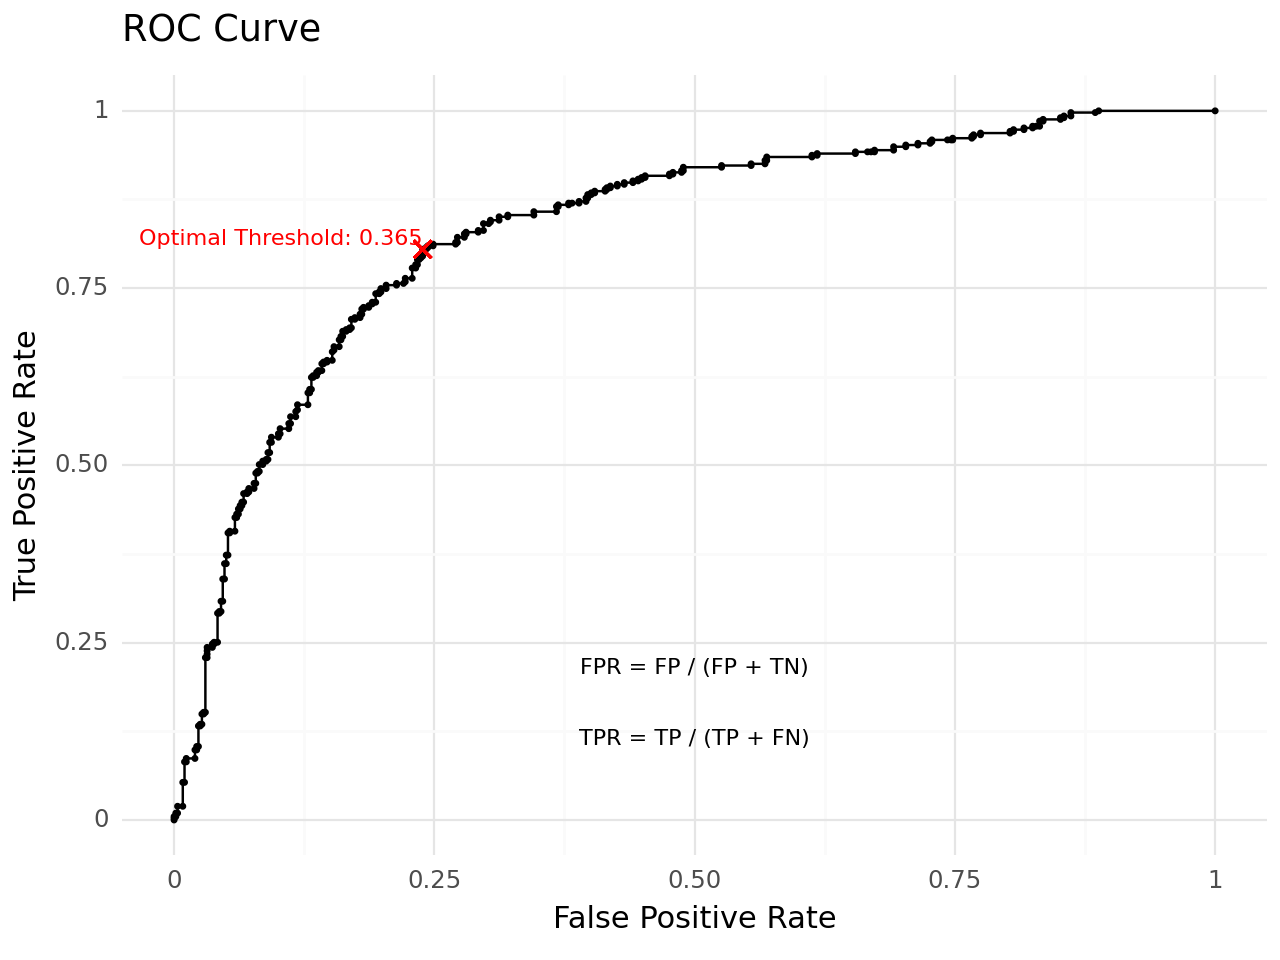


Optimal threshold: 0.36495742201805115
Classification Report XGBClassifier:
              precision    recall  f1-score   support

        True       0.70      0.80      0.75       415
       False       0.85      0.76      0.80       599

    accuracy                           0.78      1014
   macro avg       0.77      0.78      0.77      1014
weighted avg       0.79      0.78      0.78      1014

Total: 1014 datapoints
Ground truth: 415 positive, 599 negative
Prediction: 476 positive, 538 negative


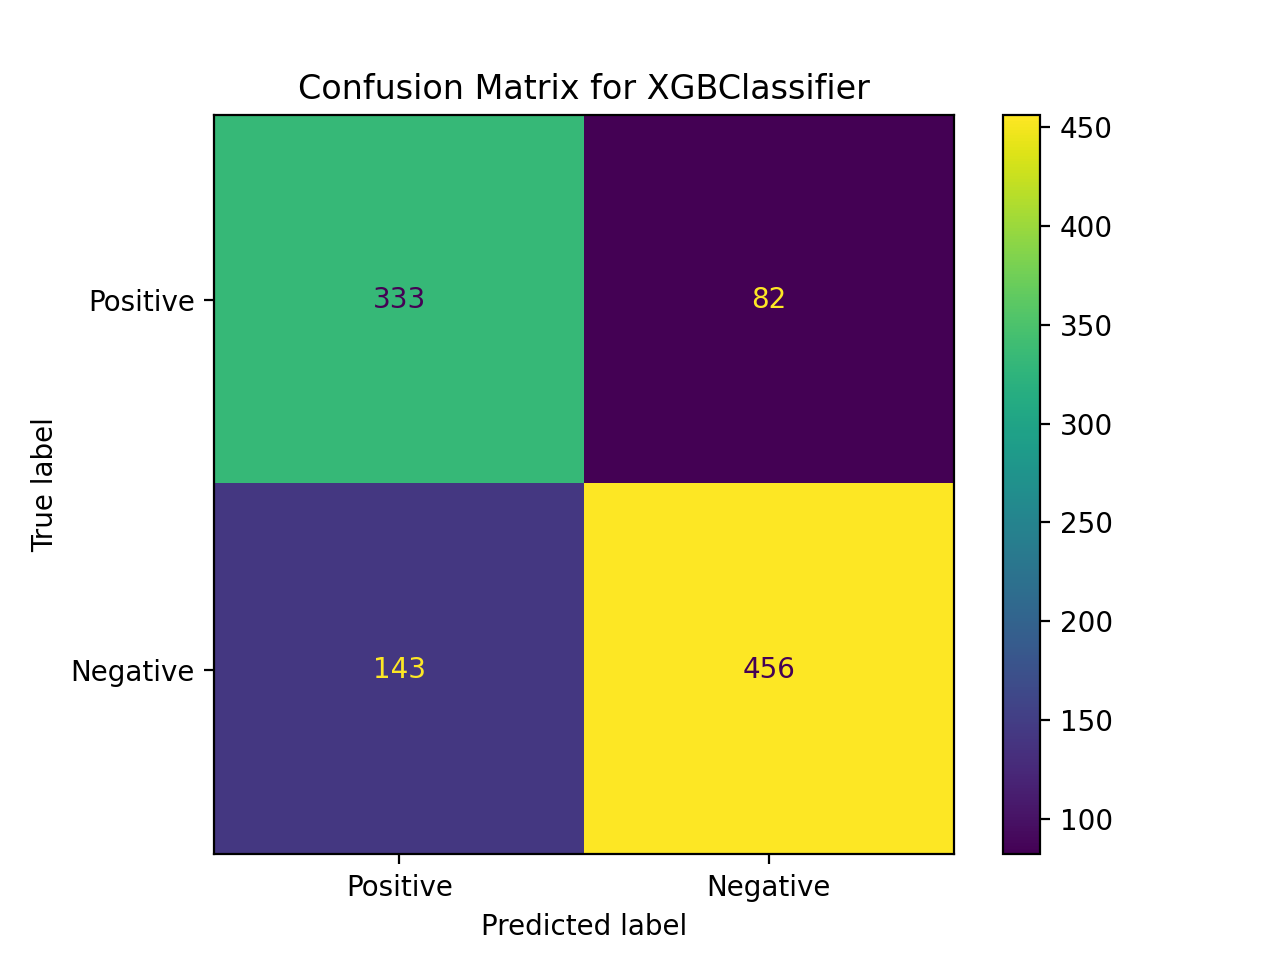

Done: XGBClassifier >> 76.48 seconds.
___________________________________________________________________________


Done. Total time >> 76.48 seconds.



In [31]:
config = load_config(CONFIG_PATH)

total_time_start = time.time()

for classifier in config['classifiers']:
    start_time = time.time()
    
    # Build the pipeline for the current classifier
    pipeline = build_pipeline(classifier['steps'])

    # Perform grid search on the extracted hyperparameters
    grid_search = grid_search_cv(classifier, pipeline)

    # Predict on the validation set and best estimator
    predict_and_report(classifier, grid_search.best_estimator_)

    print(f"Done: {classifier['name']} >> {round(time.time() - start_time, 2)} seconds.\n{'_' * 75}\n\n")

print(f"Done. Total time >> {round(time.time() - total_time_start, 2)} seconds.\n")


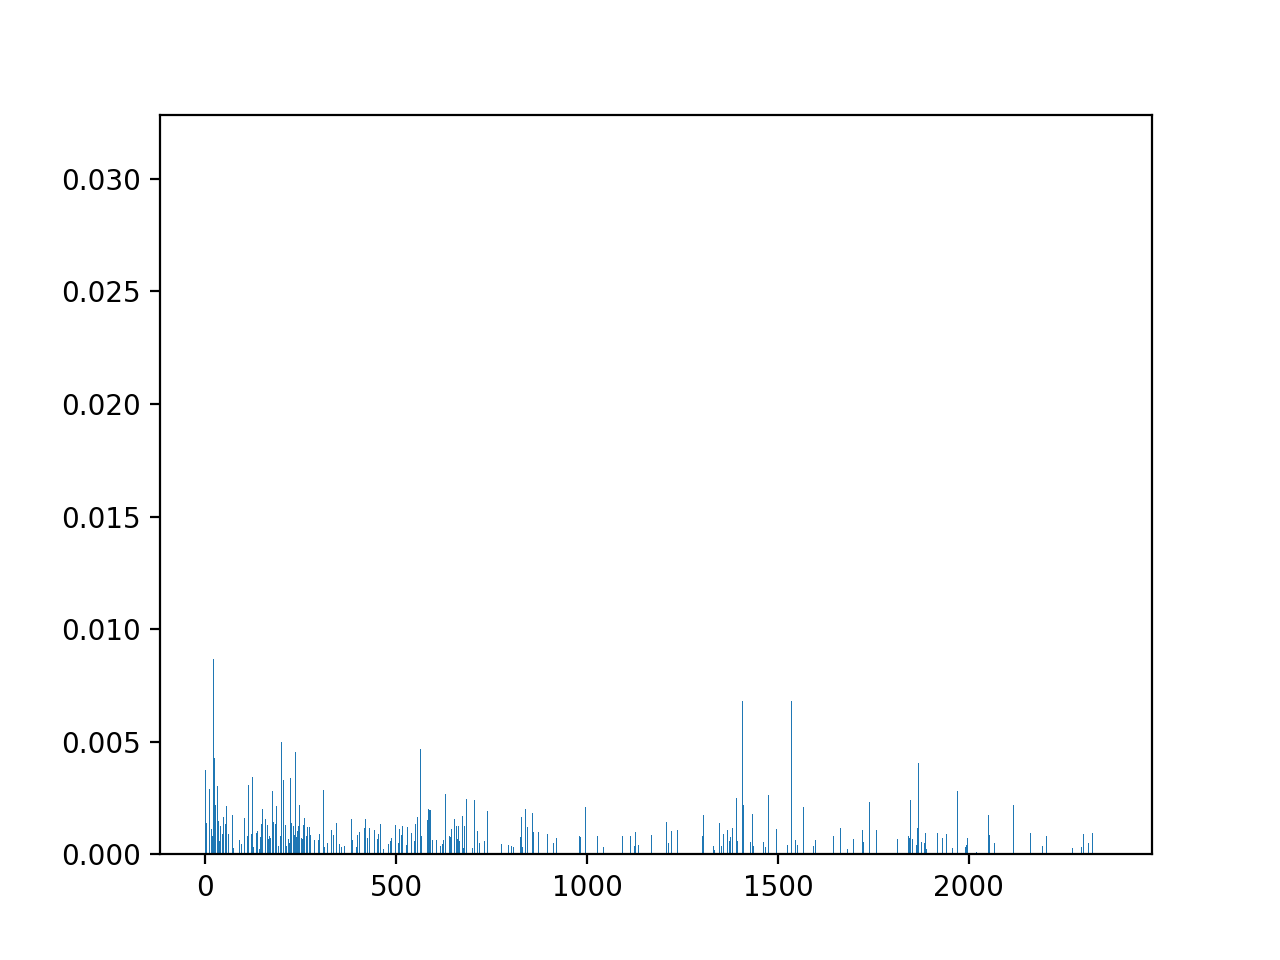

In [30]:

model = grid_search.best_estimator_['XGBClassifier']
feature_importances = model.feature_importances_
# plot_importance(model)
# plt.show()
# plot
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

In [68]:
from numpy import sort
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
# select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)

    select_X_test = selection.transform(X_test)
    predict_and_report(selection_model, grid_search.best_estimator_)

    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Thresh=0.000, n=2362, Accuracy: 87.93%


KeyboardInterrupt: 